#                     FINANCIAL DERIVATIVES - Yerai Díaz Castro

The attached file “DDTPS.pdf” provides information on an option-based structured security issued by JPMorgan Chase & Co., the Dual Directional Trigger Participation Security (or DDTPS), written on the level of the S&P 500 index, maturing on July 6, 2022.
Assuming the date is 6 January 2022. The S&P 500 index closed at 4696.05. The continuously compounded dividend yield of the index is estimated to be 1.70287%.

The call put parity equation, which only works for European options and describes the relationship or connection between options and puts, must be used to determine the annualised compounding risk free rate. According to the call put parity formula, the difference in price between any call and put option with the same strike price is equal to the stock price minus the strike price discounted using the Risk Free rate, minus the present value of the divided. Here you can see the equation:

                                  Call - Put = S0 - Ke(-rt) - De(-yt)

                           S0: Stock price                          K: Strike Price
       R: Risk free rate                      Y: Dividend yield                            T: Time to maturity
       
Finally, we ran a regression model to obtain the risk free rate. Here you can see the equation:
    
                                          Call - Put = alpha - Beta * K
                                    
         Alpha: S0 - Dividend exponential(-yt)                               Beta: exponential(-rt)
             Constant of the regression                                            Coefficient 

Our Risk free rate calculated from the regression was 1.41.

In [101]:
import pandas as pd 
import numpy as np 
import math
import statsmodels.api as sm
import seaborn as sns
import csv
from scipy.optimize import minimize 
from scipy.stats import norm
from statsmodels.api import OLS
from matplotlib import pyplot as plt
from matplotlib import figure, rcParams
plt.rcParams['figure.figsize'] = (12, 8)
#!pip install opstrat
#import opstrat
import warnings
warnings.filterwarnings('ignore')

In [102]:
#We create a function to import our data
def csvfile(filename):
    with open(filename,'r') as instream: 
        csvreader=csv.reader(instream)
        lines=[]
        for line in csvreader:
            lines.append(line)
    return lines

#We import our csv
data = csvfile('FDData.csv')

#We create a dataframe, rename the colums and delete the empty ones
options = pd.DataFrame(data)          
options.columns = options.iloc[0]         
options = options[options['Call Bid Price'] != '']
options.drop(index = 0 , inplace=True)
options = options.astype(float)
options.reset_index(inplace = True)
options.drop(columns = 'index' , inplace=True)
options.head(100)

,Strike,Call Bid Price,Call Ask Price,Put Bid Price,Put Ask Price
0,3000.0,1697.10,1710.50,25.6,26.4
1,3050.0,1648.90,1662.20,27.3,28.1
2,3100.0,1603.40,1613.10,29.1,30.0
3,3150.0,1555.60,1565.20,31.1,32.0
4,3200.0,1508.00,1517.40,33.2,34.1
5,3250.0,1460.50,1469.80,35.5,36.4
6,3300.0,1413.20,1422.40,37.9,38.9
7,3350.0,1363.80,1375.10,40.6,41.6
8,3400.0,1316.80,1328.10,43.5,44.4
9,3450.0,1270.20,1281.30,46.6,47.5


In [103]:
#We create a list for the call minus put
call_put = []
for i in range(57) :
    callminusput = options['Call Bid Price'][i] - options['Put Bid Price'][i]
    call_put.append(callminusput)

<AxesSubplot:title={'center':'Relationship between the Strike and Call and Put prices'}, xlabel='Strike prices', ylabel='Option prices'>

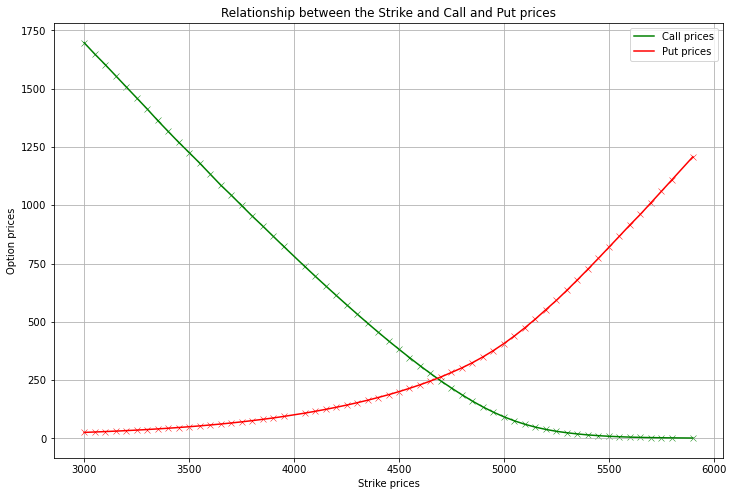

In [104]:
#We plot the relationship between the strike and call put prices
figure, (ax1) = plt.subplots()
ax1.plot(options['Strike'],options['Call Bid Price'], label = 'Call prices', color='green')
ax1.plot(options['Strike'],options['Put Bid Price'], label = 'Put prices', color='red')
ax1.set_ylabel('Option prices')
ax1.set_xlabel('Strike prices')
ax1.set_title('Relationship between the Strike and Call and Put prices')
plt.grid()
ax1.legend()
sns.scatterplot(options['Strike'],options['Call Bid Price'], color='green', marker = 'x')
sns.scatterplot(options['Strike'],options['Put Bid Price'], color='red', marker = 'x')



In [105]:
#We use the linear Regression to estimate Beta. The lr_x will be the strike price and the lr_y will be Call - Put
lr_x = np.array(options['Strike']) 
lr_y = np.array(call_put)     

#We use the linear Model Library 
X = sm.add_constant(-lr_x)
results = OLS(lr_y,X).fit()        


s= 4696.05
timetomaturity = 0.5
yieldd = 1.70287/100


#We divide the risk free rate by two because the time is just 0.5
##/np.exp(yieldd*time_to_maturity)
implieddividend = (s-results.params[0])
riskfreerate = (-math.log(results.params[1])/timetomaturity)

print('Implied Dividend =', implieddividend)
print('Intercept =' , results.params[0])
print('Beta =' , results.params[1])
print('Risk Free rate(%) =', riskfreerate*100)
print(results.summary())

Implied Dividend = 45.09127391410948
Intercept = 4650.958726085891
Beta = 0.9929509196157327
Risk Free rate(%) = 1.4148085054673898
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.400e+07
Date:                Mon, 09 May 2022   Prob (F-statistic):          5.95e-161
Time:                        02:25:12   Log-Likelihood:                -84.514
No. Observations:                  57   AIC:                             173.0
Df Residuals:                      55   BIC:                             177.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]

We will mention two scenarios for the construction of our payoff. 
The first scenario shows the following:
- Underlying 
- Bull call spread at 0 - 15 %
- Two Put options with strike price of the inicial stock price. This is called a vanilla option
- Short Two Put options with strike price of 0.9 the initicial stock price. This is called a vanilla option
- Sell Cash or Nothing Put with strike price of 0.9 the initicial stock price

Here we can observe how the Two puts and underlying will match the DDTPS between 0 and -10 percent, and below that, the Cash-or-nothing call price will be exercised, pushing the payout down. Moreover, the two short puts will cancel the two long puts, leaving just the underlying. On the other hand, the risk associated with a bull call spread is reduced since the investor may only lose the net cost of creating the spread.

The second scenario shows the following:
- Underlying
- Short call option with strike price of 1.2 the initicial stock price. This is called a vanilla option.
- Two down and out put with barriers of 0.9 the initicial stock price. This is called a exotic option.

Here we can observe how between 0% and 10% loss, two puts with the underlying can mirror DDTPS' reaction; however, at exactly 10% loss, we need a knockout barriers option to end the make the outs worthless and return to the underlying payoff, so we use two down and out puts with parries at -10% the underlying instead of two puts. Moreover, between 0% and 20% increase in stock price, the DDTPs mirror the underlying’s payoff after 20% increase the stabilized payoff can occur through shorting a call option at the 20% intital stock price.

Provide a competitive bid and ask price (in USD) for the DDTPS, using the S&P 500 index level and option prices downloaded from Cboe, Bloomberg, or another source. State clearly the price used, the assumptions made, and the modelling framework.

We have downloaded the data from Bloomberg. We have then created this table providing the data to determine the ask and bid price of our ddtps with no arbitrary condition between them. To determine the DDPTS price, we suppose that we have two portfolios with the identical payoffs.

As you can see we use the implied dividend calculated above.
The short term bid and ask prices have been taken from the bid and ask prices of different strike prices. To arrive at these values we have taken the strike price of the underlying 4696 and calculated 15%(5400) on up, and 10%(4226.4) on down. We have taken the strike price value of 4250 as it was closer. 

For the down we have taken the Put Bid and Put Ask price values. 
For the up we have taken the Call bid and Call Ask price values.
It is important to mention that it is divided by the strike price of the underlying(4696.05) because we assume that we have a portfolio that includes the underlying.

Secondly, We will use the binomial tree to calculate the price of our DDTPSS and see if there is a very large difference between our assumptions or not. A binomial tree is a graphical depiction of the multiple intrinsic values that an option might have at various nodes or time periods. The option's value is determined by the underlying asset (stock or bond), and the value of the option at each node is determined by the chance that the underlying asset's price will decline or grow at that node.

Finally, it can be seen that the price of our DDTPS in our binomial tree is 10.04 and that of our assumptions is 10.17, and it can be seen that the difference is not very high.

In [106]:
#We create our own table based on the data provided and the calculations made. We get the implied dividend calculated before.
#The short call and down&out puts has been taking from the call and put prices of different strike prices.
#
price_table = pd.DataFrame(columns=['Ask','Bid'],index=['underlying','dividend','short Call','down&out Puts'])
price_table['Bid'],price_table['Ask'] = [4696.05,-45.09, -14.8, 142.7] , [4696.05,-45.09, -15.7, 144.0]
price_table.loc['Portfolios price'] = [ sum(price_table['Bid']), sum(price_table['Ask'])]
price_table.loc['DDTPS price'] = [10*4778.86/4696.05 , 10*4779.26/4696.05]

price_table.head(10)

,Ask,Bid
underlying,4696.05000,4696.050000
dividend,-45.09000,-45.090000
short Call,-15.70000,-14.800000
down&out Puts,144.00000,142.700000
Portfolios price,4778.86000,4779.260000
DDTPS price,10.17634,10.177191


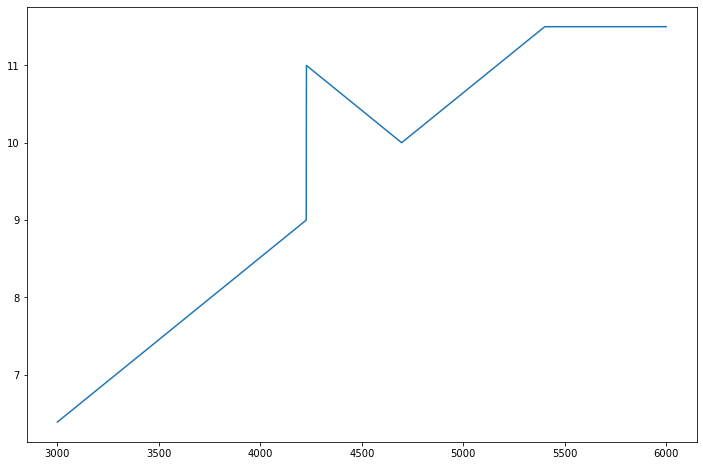

The price of the DDTPS is = 10.046873428517818


In [107]:
#We import the library yahoo finance to calculate the mean and the volatility based on historical data.
import yfinance as yf
sp = yf.Ticker('^GSPC')
pricesp = sp.history(start='2020-01-01', end='2022-01-01').Close 
returnsp = pricesp.pct_change().dropna()  
m = np.mean(returnsp) 
vol = np.std(returnsp)


#We define the functions to calculate the difference the price of the DDTPS. 15% up for 11.5 and 10% down if the price is less than s0.
def payoffddtps(s0, price):
    payoff = 0
    difference = (price - s0) / s0  
    
    if price >= s0:
        payoff =  (1 + difference) * 10
        if payoff > 11.5:  
            payoff = 11.5
    
    if price < s0:
        if difference > -0.1:    
            payoff = (1 + abs(difference)) * 10
        else:
            payoff = (1 + difference) * 10
    
    return payoff


def binomialtree(K, T, n, r, s0, u, d, mu, div, sigma, payoffparam = None):
    delt = T / n
    u = np.exp(sigma * delt ** 0.5)
    d = 1/u
    q = (np.exp((r - div) * delt) - d)/(u-d)

    
    #We create a 3 dataframes for the prices, payoff and values
    prices = pd.DataFrame(np.zeros(shape=(n + 1, n + 1)))
    payoff = pd.DataFrame(np.zeros(shape=(n + 1, n + 1)))    
    value = pd.DataFrame(np.zeros(shape=(n + 1, n + 1)))     
    prices.loc[0][0] = s0
    
    
    #We calculate the hedge ratio and the amount of mma
    m = pd.DataFrame(np.zeros(shape=(n + 1, n + 1)))  
    b = pd.DataFrame(np.zeros(shape=(n + 1, n + 1)))  

     
    for i in range(n + 1):
        for a in range(n + 1):
                # Constructing the possible price paths
                prices.loc[i][a] = prices.loc[0][0] * u ** (a - i) * d ** i
                payoff.loc[i][a] = payoffddtps(s0, prices.loc[i][a])
    
    
    #Now we introduce the discounted factor
    for i in range(n + 1):
        value[n][i] = payoff[n][i]
    
    discountedfactor = np.exp(-r * delt) 

    
    #Now we define the up and down value to calculate the the node up and down prices
    for i in range(1, n):
        for a in range(0, n):
            if a <= n - i:
                downvalue = value.loc[a + 1][n - i + 1]
                upvalue = value.loc[a][n - i + 1]              
                downprice = prices.loc[a + 1][n - i + 1]      
                upprice = prices.loc[a][n - i + 1]           
                b.loc[a][n - i] = np.exp(-r*delt)*((u * downvalue - d * upvalue)/(u-d))
                m.loc[a][n - i] = (upvalue - downvalue) / ((upprice - downprice))
                value.loc[a][n - i] = (q * upvalue + (1 - q) * downvalue) * discountedfactor 
      
    
    #At a time 0 we will calculate the value. Its going to provide us the prices, the payoff and the value 
    downtime0 = value.loc[1][1]
    uptime0 = value.loc[0][1]
    b.loc[0][0] = np.exp(-r * delt) * ((u * downtime0 - d * uptime0) / (u - d))
    m.loc[0][0] = (uptime0 - downtime0) / ((u - d) * s0)
    value.loc[0][0] = (q * uptime0 + (1 - q) * downtime0) * discountedfactor

    return prices, payoff, value 


#We create an empty list to store those values. We then assign the parameters of our binomial tree function
#using the mu and vol previously calculated with yahoofinance.
values = []
prices, payoff, value= binomialtree(s0=4696.05, u=0.1, d =0.1, mu= m, sigma=vol, r=0.0105, K=95, T=0.5, n = 126, div = 0.020)


#Now we plot our payoffs
payoffs = []
prices = np.arange(3000, 6000)
for i in prices:
    payoffs.append(payoffddtps(4696.05, i))
plt.plot(prices, payoffs)
plt.show()



print('The price of the DDTPS is =', value[0][0])

Using Black-Scholes formula or basic numerical methods, calculate the Greeks (delta, gamma, vega, theta, rho) for DDTPS, and clearly state your assumptions. Interpret your findings, and provide hedging strategies for the writer of the product.

The Implied Volatility is = 0.6822265624999997


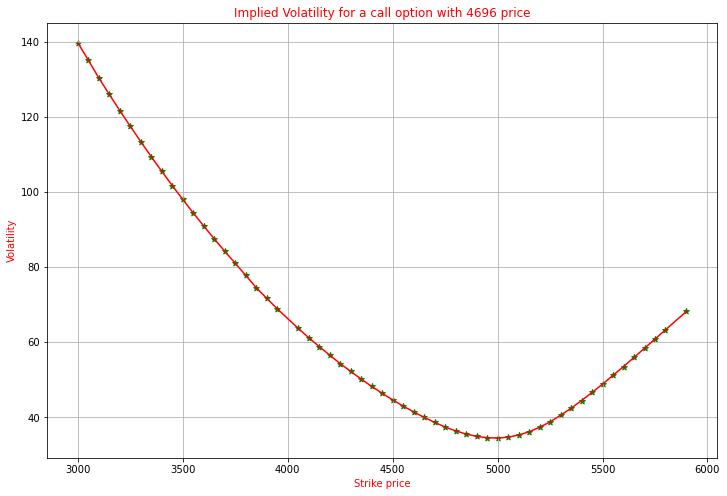

In [108]:
#We calculate the implied volatility of a call option of Bloomberg with the previous data provided in the DDTPS.
stockprice = 4696.05   
q = 0.01702   
r = riskfreerate
time = 0.5    

def impliedvol(vol):
    iv1 = ((np.log(stockprice/K) + (r-q+0.5*vol**2)*time))/vol*time**0.5
    iv2 = ((np.log(stockprice/K) + (r-q-0.5*vol**2)*time))/vol*time**0.5
    callpriceestimated = stockprice*np.exp(-q*time)*norm.cdf(iv1) -  K*np.exp(-r*time)*norm.cdf(iv2)
    
    return (callpriceestimated - actual_price)**2



stocklist = []
impliedvollist =[]
for i in range(57): 
    K = options['Strike'][i]
    actual_price = options['Call Ask Price'][i]
    res = minimize(impliedvol, 1, method = 'Nelder-Mead')
    impliedvolatility = res.x[0]
    stocklist.append(K)
    impliedvollist.append(impliedvolatility)


#Now we calculate the implied volatility of our DDTPS. Moreover, we will use the actual price of the DDTPS
actualprice = 0.55 

res = minimize(impliedvol, 1, method ='Nelder-Mead')
impliedvolatility = res.x[0]
print('The Implied Volatility is =', impliedvolatility)


#Now we pot our implied volatility when the price of the call is 4696
plt.scatter(stocklist,[i*100 for i in impliedvollist], color='green', marker = '*')
sns.lineplot(stocklist,[i*100 for i in impliedvollist], color='red', alpha = 2)
plt.title('Implied Volatility for a call option with 4696 price', color='red')
plt.xlabel('Strike price', color='red')
plt.ylabel('Volatility', color='red')
plt.grid()

#stocklist.single_plotter(spot=460, strike=460, op_type='p', tr_type='s', op_pr=12.5)

The following formulas can be used to calculate the Call and Put options for the Greeks:
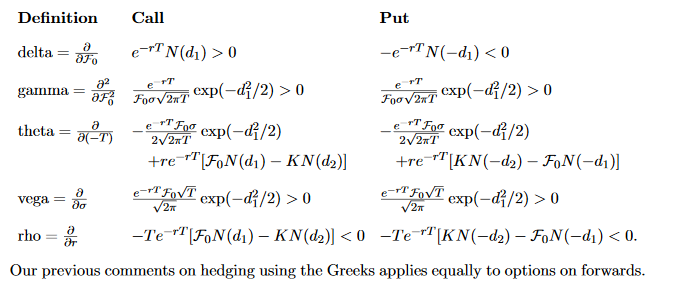

In [109]:
#We define the functions to calculate our greeks later on

def greekscall(stockprice, K, r, vol, time, q=0): 
        greeks = ((np.log(stockprice/K) + (r-q+0.5*vol**2)*time))/vol*time**0.5
        greeks2 = ((np.log(stockprice/K) + (r-q+0.5*vol**2)*time))/vol*time**0.5
        delta = np.exp(-q*time)*norm.cdf(greeks)
        theta = - np.exp(-q*time)* stockprice*norm.cdf(greeks)*vol/2*time**0.5 \
            - r*K*np.exp(-r*time)*norm.cdf(greeks2) + q*stockprice*np.exp(-q*time)*norm.cdf(greeks)
        gamma = K*np.exp(-r*time)*norm.cdf(greeks2)/(vol*(time**0.5)*(stockprice**2))
        vega= K*np.exp(-r*time)*norm.cdf(greeks2)*(time**0.5)
        rho = K*time*np.exp(-r*time)*norm.cdf(greeks2)
        
        return delta,gamma,theta,vega,rho

def greeksput(stockprice, K, r, vol, time, q=0):
        greeks = ((np.log(stockprice/K) + (r-q+0.5*vol**2)*time))/vol*time**0.5
        greeks2 = ((np.log(stockprice/K) + (r-q+0.5*vol**2)*time))/vol*time**0.5
        delta = -np.exp(-q*time)*norm.cdf(-greeks)
        theta = - np.exp(-q*time)* stockprice*norm.cdf(greeks)*vol/2*time**0.5 \
            + r*K*np.exp(-r*time)*norm.cdf(-greeks2) - q*stockprice*np.exp(-q*time)*norm.cdf(-greeks)
        gamma = K*np.exp(-r*time)*norm.cdf(greeks2)/(vol*(time**0.5)*(stockprice**2))
        vega= K*np.exp(-r*time)*norm.cdf(greeks2)*(time**0.5)
        rho = -K*time*np.exp(-r*time)*norm.cdf(-greeks2)
        
        return delta,gamma,theta,vega,rho

    
#Delta, theta, gamma, vega, and rho of our portfolio

delta_u,gamma_u,theta_u,vega_u,rho_u = 1,0,0,0,0
delta_c,gamma_c,theta_c,vega_c,rho_c = greekscall(4696.05,5635,riskfreerate,\
                                                   impliedvolatility, q = 0.01702, time =0.5)
delta_p,gamma_p,theta_p,vega_p,rho_p = greeksput(4696.05,4696.05,riskfreerate,\
                                                  impliedvolatility, q = 0.01702, time = 0.5)
        
deltaport = -delta_c + delta_p + delta_u
thetaport = -theta_c + theta_p + theta_u
gammaport = -gamma_c + gamma_p + gamma_u
vegaport = -vega_c + vega_p + vega_u
rhoport = -rho_c + rho_p + rho_u

        

#Now we print our results and we divide the deltas between 469.605 to make it equal due to the price of our underlying
#Since DDTPS gives you the percentage of 10$, then we should multiply by ten which is the same than divided by 469.605.
print('Delta =',deltaport, 'Delta =',deltaport/469.605 )
print('Theta =',thetaport,'Theta =',thetaport/469.605)
print('Gama =', gammaport, 'Gama =', gammaport/469.605)
print('Vega =',vegaport, 'Vega =',vegaport/469.605)
print('RHO =',rhoport, 'RHO',rhoport/469.605)  


Delta = 0.08307094102335033 Delta = 0.00017689535039735593
Theta = -90.54683290566095 Theta = -0.1928148825196941
Gama = -8.404076053899773e-06 Gama = -1.7896053180651343e-08
Vega = -63.21993246534021 Vega = -0.13462363574778846
RHO = -2376.1768259831288 RHO -5.059947883823913


REFERENCES:

https://towardsdatascience.com/python-for-finance-stock-portfolio-analyses-6da4c3e61054